In [1]:
import pandas as pd 
import pydeck as pdk
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import networkx as nx
import copy
from tqdm import tqdm
import re

In [2]:
df = pd.read_csv("data/nyc_week_agg_2024_08012024_09012024.csv")

In [3]:
df.head()
# print(df.dtypes)

,Year,Month,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Origin Latitude,Origin Longitude,Destination Station Complex ID,Destination Station Complex Name,Destination Latitude,Destination Longitude,Estimated Average Ridership,Origin Point,Destination Point
0,2024,1,Monday,0,01/08/2024 12:00:00 AM,55,"Brighton Beach (B,Q)",40.577621,-73.961376,609,"Bryant Pk (B,D,F,M)/5 Av (7)",40.754022,-73.983266,0.2666,POINT (-73.961376 40.577621),POINT (-73.983266 40.754022)
1,2024,1,Monday,0,01/08/2024 12:00:00 AM,259,"Kew Gardens-Union Tpke (E,F)",40.714441,-73.831008,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.755746,-73.987581,1.7108,POINT (-73.831008 40.714441),POINT (-73.987581 40.755746)
2,2024,1,Monday,0,01/08/2024 12:00:00 AM,340,"Grand Army Plaza (2,3)",40.675235,-73.971046,277,"7 Av (E,B,D)",40.762862,-73.981637,1.2126,POINT (-73.971046 40.675235),POINT (-73.981637 40.762862)
3,2024,1,Monday,0,01/08/2024 12:00:00 AM,383,183 St (4),40.858407,-73.903879,602,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",40.735066,-73.990416,1.0974,POINT (-73.903879 40.858407),POINT (-73.990416 40.735066)
4,2024,1,Monday,0,01/08/2024 12:00:00 AM,602,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",40.735066,-73.990416,167,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",40.732338,-74.000495,1.6580,POINT (-73.990416 40.735066),POINT (-74.000495 40.732338)


In [4]:
a = list(df.columns)
remove = ['Year', 'Month', 'Day of Week', 'Timestamp', 'Origin Point', 'Destination Point', 'Origin Station Complex ID', "Destination Station Complex ID", 'Estimated Average Ridership']
for b in remove: 
    a.remove(b)
print(a)

df_agg = (df.groupby(a, as_index = False))['Estimated Average Ridership'].sum()
print(len(df_agg))
df_agg.head(n=30)

['Hour of Day', 'Origin Station Complex Name', 'Origin Latitude', 'Origin Longitude', 'Destination Station Complex Name', 'Destination Latitude', 'Destination Longitude']
1430318


,Hour of Day,Origin Station Complex Name,Origin Latitude,Origin Longitude,Destination Station Complex Name,Destination Latitude,Destination Longitude,Estimated Average Ridership
0,0,1 Av (L),40.730953,-73.981628,103 St (1),40.799446,-73.968379,0.9402
1,0,1 Av (L),40.730953,-73.981628,103 St (6),40.790600,-73.947478,0.2550
2,0,1 Av (L),40.730953,-73.981628,"103 St (C,B)",40.796092,-73.961454,0.6088
3,0,1 Av (L),40.730953,-73.981628,103 St-Corona Plaza (7),40.749865,-73.862700,0.4140
4,0,1 Av (L),40.730953,-73.981628,104 St (A),40.681711,-73.837683,1.6408
5,0,1 Av (L),40.730953,-73.981628,"104 St (J,Z)",40.695178,-73.844330,0.2444
6,0,1 Av (L),40.730953,-73.981628,116 St (6),40.798629,-73.941617,0.9200
7,0,1 Av (L),40.730953,-73.981628,"116 St (C,B)",40.805085,-73.954882,0.2628
8,0,1 Av (L),40.730953,-73.981628,116 St-Columbia University (1),40.807722,-73.964110,0.4820
9,0,1 Av (L),40.730953,-73.981628,125 St (1),40.815581,-73.958372,0.7020


1430318it [16:29, 1445.32it/s]


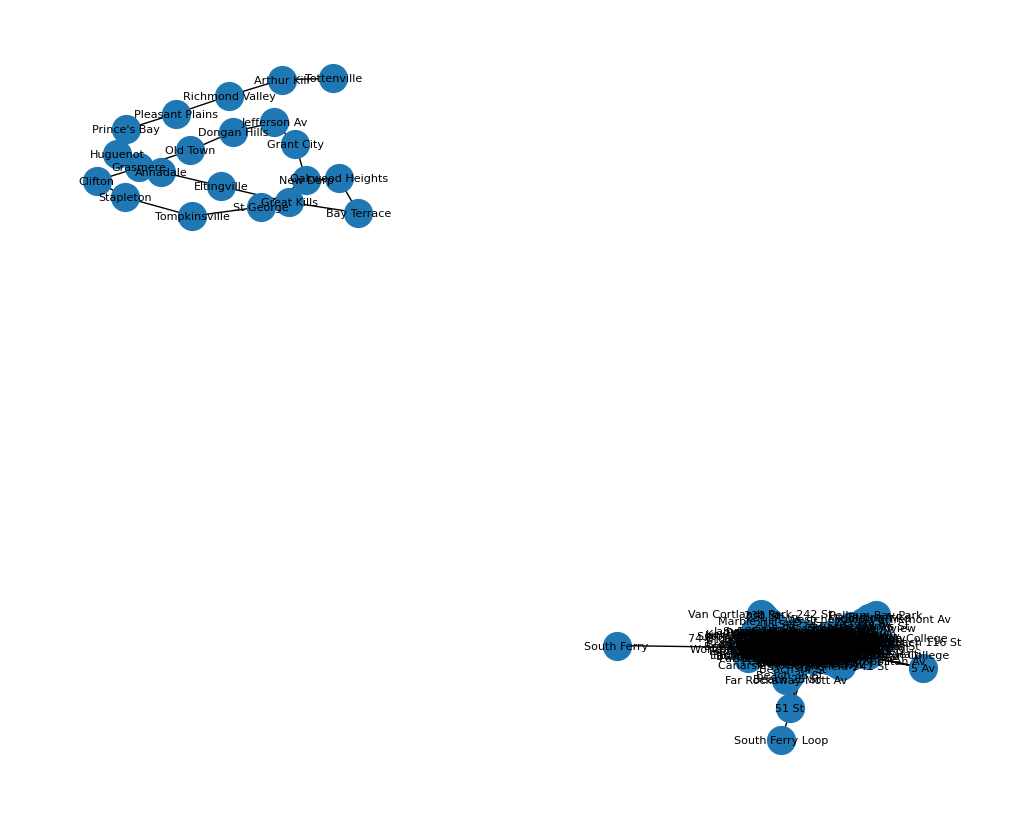

In [15]:
transport_graph = nx.read_gml("data/subway_graph.gml")
transport_traffic = copy.deepcopy(transport_graph)

def clean_nodes(src): 
    # print(src)
    # to remove brackets denoting connecting lines @ stations
    src = re.sub(r"\s*\([^)]*\)", "", src)
    src = re.sub(r"\s*/\s*", "-", src)
    # print(src)
    return src

for _, row in tqdm(df_agg.iterrows()):

    src = clean_nodes(row["Origin Station Complex Name"])
    dst = clean_nodes(row["Destination Station Complex Name"])

    est_ridership = row["Estimated Average Ridership"]

    try:
        if nx.has_path(transport_graph, src, dst): 
            paths = list(nx.all_shortest_paths(transport_graph, src, dst))
            if not paths:
                continue

            weight_increment = est_ridership / len(paths)

            for path in paths:
                for u, v in zip(path[:-1], path[1:]):
                    if transport_traffic.has_edge(u, v):
                        current_weight = transport_traffic[u][v].get("weight", 0)
                        transport_traffic[u][v]["weight"] = current_weight + weight_increment
                    else:
                        print("you're literally schewpeed")
    except Exception as e: 
        print(e)


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(transport_traffic, seed=42)
nx.draw(transport_traffic, pos, with_labels=True, node_size=400, font_size=8)
plt.show()

In [22]:
nx.write_gml(transport_traffic, "data/subway_graph_with_weights.gml")

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

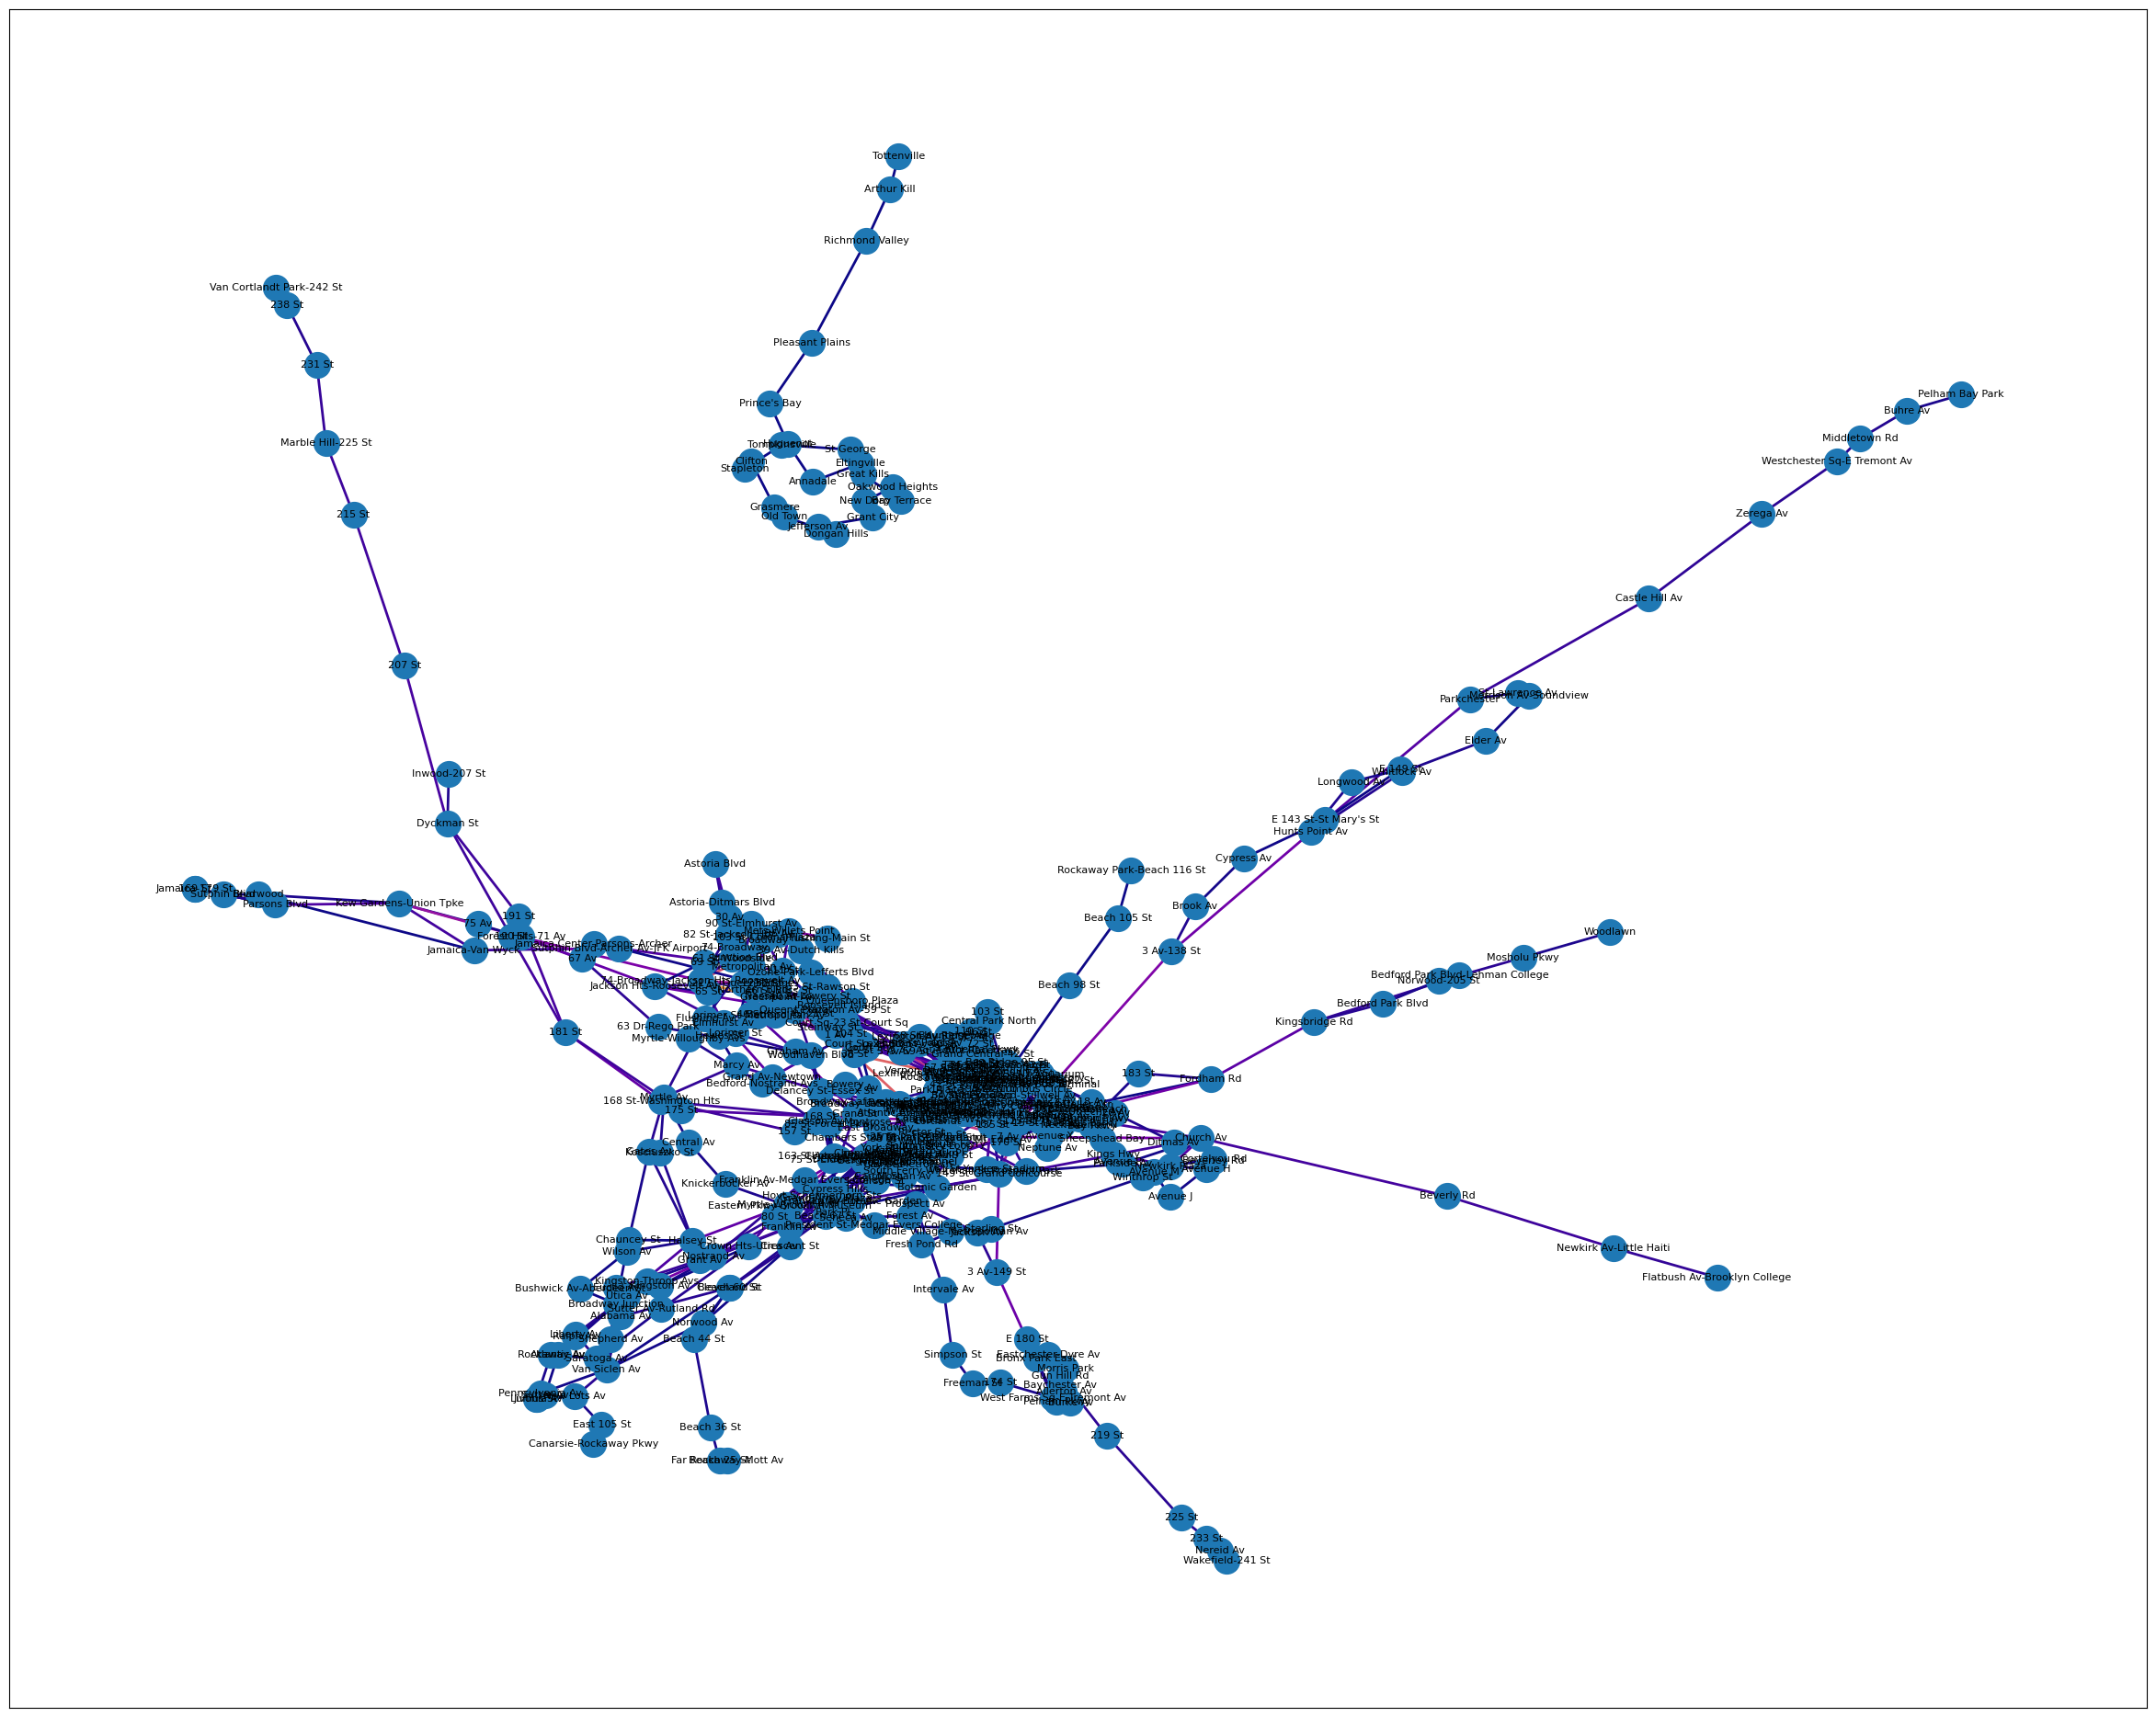

In [19]:
plt.figure(figsize=(30, 24))

pos = nx.spring_layout(transport_traffic, seed=42, k=0.001)

# extract edge weights
weights = [d.get("weight", 0) for (_, _, d) in transport_traffic.edges(data=True)]

# draw nodes
nx.draw_networkx_nodes(transport_traffic, pos, node_size=400)

# draw edges with colormap based on weights
edges = nx.draw_networkx_edges(
    transport_traffic,
    pos,
    edge_color=weights,
    edge_cmap=plt.cm.plasma,       # or 'viridis', 'inferno', etc.
    edge_vmin=min(weights),
    edge_vmax=max(weights),
    width=2
)

# draw labels
nx.draw_networkx_labels(transport_traffic, pos, font_size=8)

# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm.set_array([])
plt.colorbar(sm, label="Edge Weight Magnitude")

plt.axis("off")
plt.show()


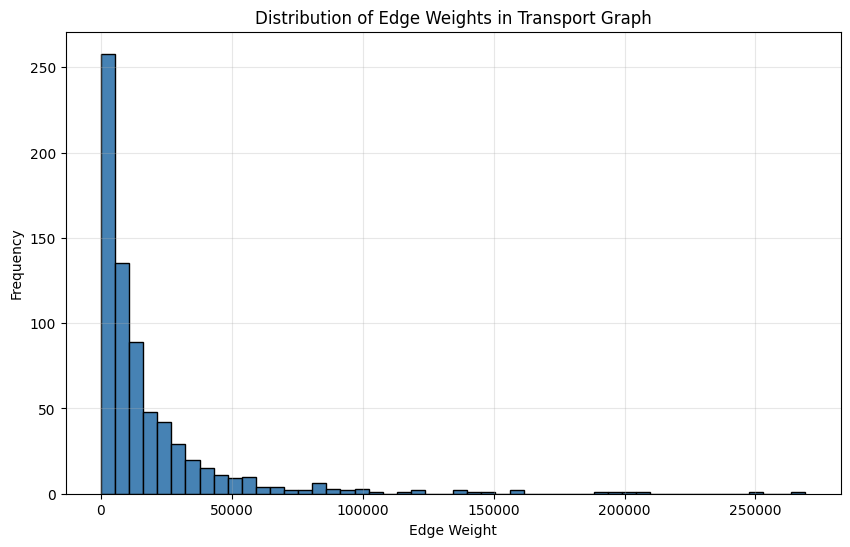

In [20]:
weights = [d.get("weight", 0) for _, _, d in transport_traffic.edges(data=True)]

plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Edge Weights in Transport Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


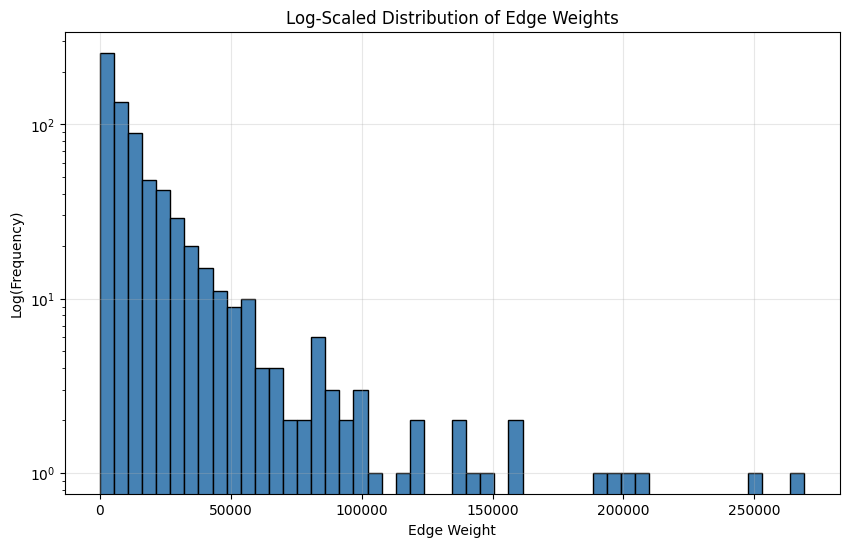

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, color="steelblue", edgecolor="black", log=True)
plt.title("Log-Scaled Distribution of Edge Weights")
plt.xlabel("Edge Weight")
plt.ylabel("Log(Frequency)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
def make_line(row):
    return LineString([
        (row['Origin Longitude'], row['Origin Latitude']),
        (row['Destination Longitude'], row['Destination Latitude'])
    ])

gdf = gpd.GeoDataFrame(df_agg, geometry=df_agg.apply(make_line, axis=1), crs="EPSG:4326")


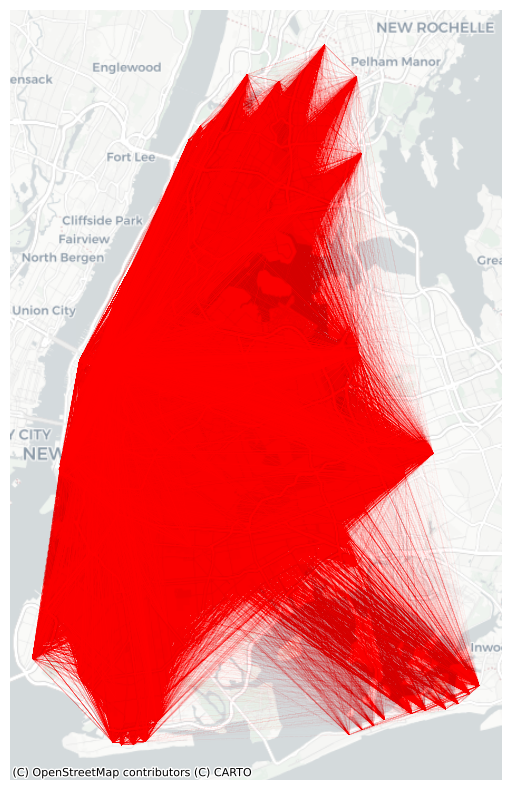

In [ ]:
gdf_merc = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_merc.plot(ax=ax, linewidth=gdf_merc['Estimated Average Ridership'] / gdf_merc['Estimated Average Ridership'].max() * 5, color='red', alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.show()